<a href="https://colab.research.google.com/github/shahensha5624/Landscape-Classification/blob/main/Landscape_Classification_(mini).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Landscape Classification (CNN - Keras)



# Import Packages

In [ ]:
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tqdm import tqdm

In [ ]:
class_names = ['buildings', 'forest', 'glacier','mountain','sea','street']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

IMAGE_SIZE = (150, 150)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Loading the Data
We have to write a load_data function that load the images and the labels from the folder.
####  Load the data:
            - 14,034 images to train the network.
            - 3,000 images to evaluate how accurately the network learned to classify images.


In [ ]:
def load_data():


    datasets = ['/content/drive/MyDrive/intel-image-classification/train','/content/drive/MyDrive/intel-image-classification/validation']
    output = []

    # Iterate through training and test sets
    for dataset in datasets:

        images = []
        labels = []

        print("Loading {}".format(dataset))

        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]

            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):

                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)

                # Open and resize the img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE)

                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)

        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')

        output.append((images, labels))

    return output

In [ ]:
(train_images, train_labels), (test_images, test_labels) = load_data()

Loading /content/drive/MyDrive/intel-image-classification/train


100%|██████████| 1000/1000 [00:36<00:00, 27.10it/s]


Loading /content/drive/MyDrive/intel-image-classification/validation


100%|██████████| 400/400 [00:07<00:00, 54.11it/s] 


In [ ]:
train_images, train_labels = shuffle(train_images, train_labels, random_state=25)

In [ ]:
n_train = train_labels.shape[0]
n_test = test_labels.shape[0]

print ("Number of training examples: {}".format(n_train))
print ("Number of testing examples: {}".format(n_test))
print ("Each image is of size: {}".format(IMAGE_SIZE))

Number of training examples: 6043
Number of testing examples: 2418
Each image is of size: (150, 150)


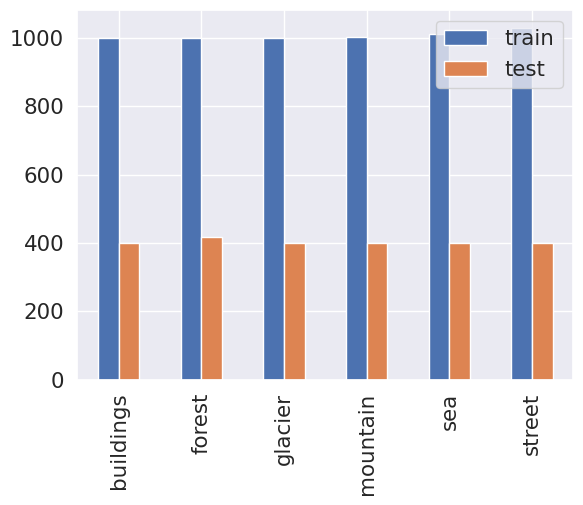

In [ ]:
import pandas as pd
import numpy as np

# ... (your previous code) ...

# Get unique labels and counts for training and testing sets
unique_train_labels, train_counts = np.unique(train_labels, return_counts=True)
unique_test_labels, test_counts = np.unique(test_labels, return_counts=True)

# Create a dictionary to store the counts for each class
data = {}
for class_name in class_names:
    data[class_name] = {'train': 0, 'test': 0}  # Initialize with 0 counts

# Update the counts for each class present in the training and testing sets
for label, count in zip(unique_train_labels, train_counts):
    data[class_names[label]]['train'] = count
for label, count in zip(unique_test_labels, test_counts):
    data[class_names[label]]['test'] = count

# Create the DataFrame using the dictionary
df = pd.DataFrame(data).T  # Transpose to have classes as index and train/test as columns
df.plot.bar()
plt.show()

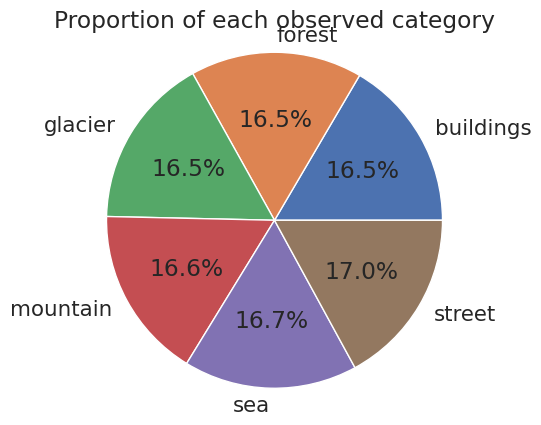

In [ ]:
# Get the unique labels and their counts from train_labels
unique_labels, counts = np.unique(train_labels, return_counts=True)

# Assuming 'class_names' contains all possible labels in the dataset
# Filter 'class_names' and 'counts' to include only those present in 'train_labels'
labels_present = [class_names[label] for label in unique_labels]
counts_present = [counts[i] for i in range(len(unique_labels))]

# Create an explode array with the same length as counts_present
# Here, we set all explode values to 0 for no offset
explode = [0] * len(counts_present)

plt.pie(counts_present,  # Use counts corresponding to present labels
        explode=explode,  # Use the generated explode array
        labels=labels_present,  # Use labels present in the training data
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proportion of each observed category')
plt.show()

In [ ]:
train_images = train_images / 255.0
test_images = test_images / 255.0

## Visualize the data
We can display a random image from the training set.

In [ ]:
def display_random_image(class_names, images, labels):
    """
        Display a random image from the images array and its correspond label from the labels array.
    """

    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{} : '.format(index) + class_names[labels[index]])
    plt.show()

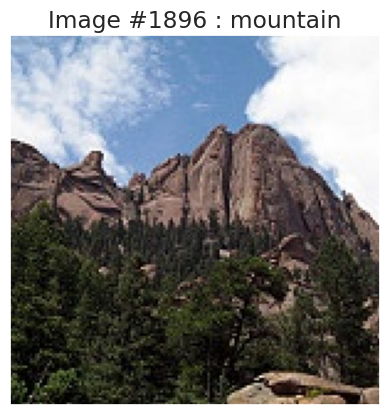

In [ ]:
display_random_image(class_names, train_images, train_labels)

In [ ]:
def display_examples(class_names, images, labels):
    """
        Display 25 images from the images array with its corresponding labels
    """

    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Some examples of images of the dataset", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()

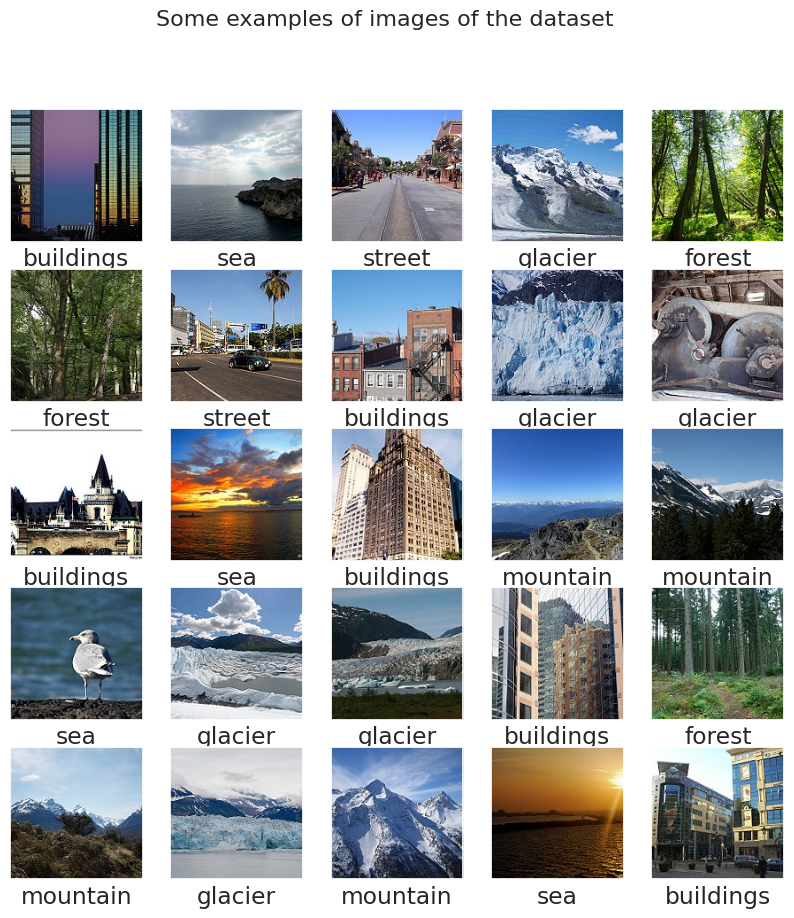

In [ ]:
display_examples(class_names, train_images, train_labels)

#  Simple CNN Model

Steps are:
1. Build the model,
1. Compile the model,
1. Train / fit the data to the model,
1. Evaluate the model on the testing set,
1. Carry out an error analysis of our model.



In [ ]:
import tensorflow as tf

# Create training dataset
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_ds = train_ds.shuffle(buffer_size=1000)
train_ds = train_ds.batch(32)  # Smaller batch size
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

# Create validation dataset (20% split)
val_size = int(0.2 * len(train_images))
val_ds = train_ds.take(val_size)
train_ds = train_ds.skip(val_size)

# Create test dataset
test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
test_ds = test_ds.batch(32)
test_ds = test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)


In [ ]:
import gc
import tensorflow as tf

gc.collect()
tf.keras.backend.clear_session()


In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Then, we can compile it with some parameters such as:
* **Optimizer**: adam = RMSProp + Momentum.

* Momentum = takes into account past gradient to have a better update.
* RMSProp = exponentially weighted average of the squares of past gradients.
* **Loss function**: we use sparse categorical crossentropy for classification, each images belongs to one class only

In [ ]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(train_images, train_labels, batch_size=32, epochs=20, validation_split=0.2)

Epoch 1/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 198s 1s/step - accuracy: 0.3958 - loss: 1.7722 - val_accuracy: 0.6055 - val_loss: 0.9602
Epoch 2/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 198s 1s/step - accuracy: 0.6715 - loss: 0.8838 - val_accuracy: 0.7196 - val_loss: 0.7536
Epoch 3/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 204s 1s/step - accuracy: 0.7727 - loss: 0.6202 - val_accuracy: 0.7295 - val_loss: 0.7369
Epoch 4/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 207s 1s/step - accuracy: 0.8661 - loss: 0.3751 - val_accuracy: 0.7469 - val_loss: 0.7873
Epoch 5/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 199s 1s/step - accuracy: 0.9408 - loss: 0.1913 - val_accuracy: 0.7428 - val_loss: 0.8962
Epoch 6/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - accuracy: 0.9619 - loss: 0.1361 - val_accuracy: 0.7138 - val_loss: 1.0224
Epoch 7/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 199s 1s/step - accuracy: 0.9693 - loss: 0.1108 - val_accuracy: 0.7246 - val_loss: 1.1295
Epoch 8/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 191s 1s/step - accuracy: 0.9954 - loss: 0.0282 - val_accu

In [ ]:
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(10,5))

    # Plot accuracy
    plt.subplot(221)
    # Changed 'acc' to 'accuracy' to reflect the new key in history.history
    plt.plot(history.history['accuracy'],'bo--', label = "acc")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_acc") # Changed 'val_acc' to 'val_accuracy'
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

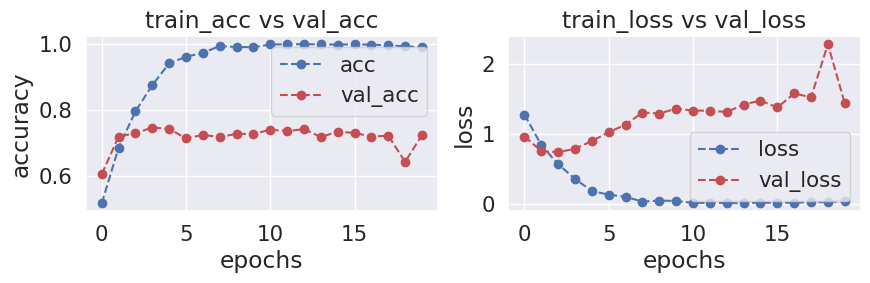

In [ ]:
plot_accuracy_loss(history)

We should evaluate the model performance on test set

In [ ]:
test_loss = model.evaluate(test_images, test_labels)

76/76 ━━━━━━━━━━━━━━━━━━━━ 33s 421ms/step - accuracy: 0.6826 - loss: 1.6722


We see that we achieve 0.76 accuracy on the testing test. We got a slight underfitting .

Let's see how the classifier is doing on random images.

76/76 ━━━━━━━━━━━━━━━━━━━━ 24s 315ms/step


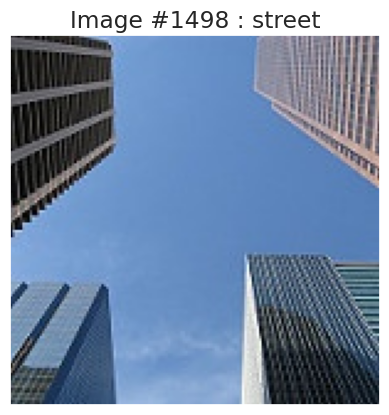

In [ ]:
predictions = model.predict(test_images)     # Vector of probabilities
pred_labels = np.argmax(predictions, axis = 1) # We take the highest probability

display_random_image(class_names, test_images, pred_labels)

## Error analysis

We can try to understand on which kind of images the classifier has trouble.

In [ ]:
def print_mislabeled_images(class_names, test_images, test_labels, pred_labels):
    """
        Print 25 examples of mislabeled images by the classifier, e.g when test_labels != pred_labels
    """
    BOO = (test_labels == pred_labels)
    mislabeled_indices = np.where(BOO == 0)
    mislabeled_images = test_images[mislabeled_indices]
    mislabeled_labels = pred_labels[mislabeled_indices]

    title = "Some examples of mislabeled images by the classifier:"
    display_examples(class_names,  mislabeled_images, mislabeled_labels)


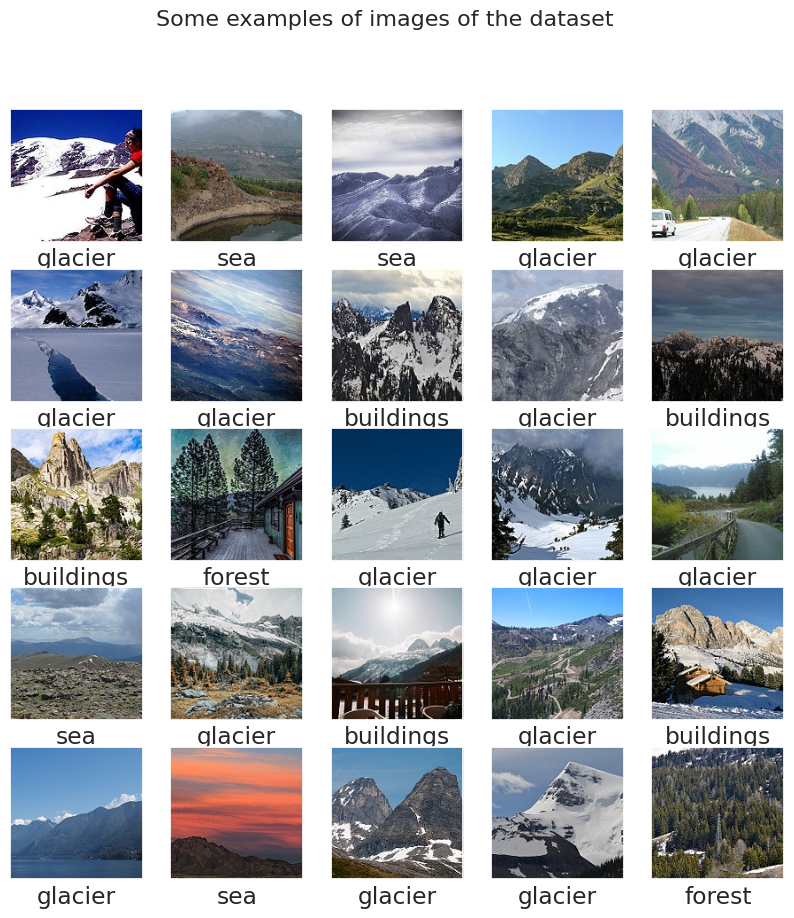

In [ ]:
print_mislabeled_images(class_names, test_images, test_labels, pred_labels)

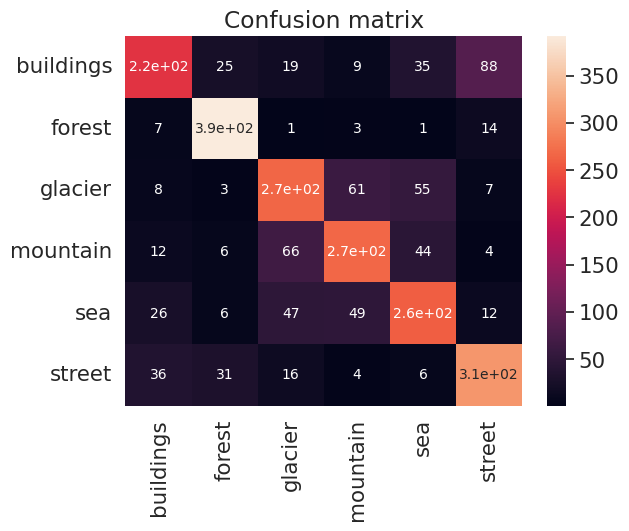

In [ ]:
CM = confusion_matrix(test_labels, pred_labels)
ax = plt.axes()
sn.heatmap(CM, annot=True,
           annot_kws={"size": 10},
           xticklabels=class_names,
           yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix')
plt.show()

## Conclusion: The classifier has trouble with 2 kinds of images.
It has trouble with street and buildings. Well, it can be understandable as as there are buildings in the street.
It has also trouble with sea, glacier and moutain as well. It is hard for me to fully distinguish them.
However, it can detects forest very accurately!

# Feature extraction with VGG ImageNet

We can extract features from VGG16.

In [ ]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input

model = VGG16(weights='imagenet', include_top=False)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Get the features directly from VGG16

In [ ]:
train_features = model.predict(train_images)
test_features = model.predict(test_images)

## Visualize the features through PCA

In [ ]:
n_train, x, y, z = train_features.shape
n_test, x, y, z = test_features.shape
numFeatures = x * y * z

In [ ]:
from sklearn import decomposition

pca = decomposition.PCA(n_components = 2)

X = train_features.reshape((n_train, x*y*z))
pca.fit(X)

C = pca.transform(X) # Représentation des individus dans les nouveaux axe
C1 = C[:,0]
C2 = C[:,1]

In [ ]:
### Figures

plt.subplots(figsize=(10,10))

for i, class_name in enumerate(class_names):
    plt.scatter(C1[train_labels == i][:1000], C2[train_labels == i][:1000], label = class_name, alpha=0.4)
plt.legend()
plt.title("PCA Projection")
plt.show()

We can identifying clusters thanks to this PCA. The clusters correspond more or less to the labels.

We see that glacier and mountain points are very close to each other, as VGG sees them as very similar.

We see that there is no distinction between building and street.


## Training on top of VGG

Let's train a simple one-layer Neural Network on the features extracted from VGG.

In [ ]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape = (x, y, z)),
    tf.keras.layers.Dense(50, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

model2.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

history2 = model2.fit(train_features, train_labels, batch_size=128, epochs=15, validation_split = 0.2)

In [ ]:
plot_accuracy_loss(history)

We should get approximately 0.844 accuracy (+0.1 accuracy) over the simple ConvNet.

In [ ]:
test_loss = model2.evaluate(test_features, test_labels)

# Ensemble Neural Networks

In [ ]:
# Number of estimators
n_estimators = 10
# Proporition of samples to use to train each training
max_samples = 0.8

max_samples *= n_train
max_samples = int(max_samples)

We define n_estimators Neural Networks.

Each Neural Network will be trained on random subsets of the training dataset. Each subset contains max_samples samples.

In [ ]:
models = list()
random = np.random.randint(50, 100, size = n_estimators)

for i in range(n_estimators):

    # Model
    model = tf.keras.Sequential([ tf.keras.layers.Flatten(input_shape = (x, y, z)),
                                # One layer with random size
                                    tf.keras.layers.Dense(random[i], activation=tf.nn.relu),
                                    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
                                ])

    model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

    # Store model
    models.append(model)

In [ ]:
histories = []

for i in range(n_estimators):
    # Train each model on a bag of the training data
    train_idx = np.random.choice(len(train_features), size = max_samples)
    histories.append(models[i].fit(train_features[train_idx], train_labels[train_idx], batch_size=128, epochs=10, validation_split = 0.1))

We aggregate each model individual predictions to form a final prediction.

In [ ]:
predictions = []
for i in range(n_estimators):
    predictions.append(models[i].predict(test_features))

predictions = np.array(predictions)
predictions = predictions.sum(axis = 0)
pred_labels = predictions.argmax(axis=1)

We should improve our result as we have a lower variance.

In [ ]:
from sklearn.metrics import accuracy_score
print("Accuracy : {}".format(accuracy_score(test_labels, pred_labels)))

# Fine Tuning VGG ImageNet

In [ ]:
from keras.models import Model

model = VGG16(weights='imagenet', include_top=False)
model = Model(inputs=model.inputs, outputs=model.layers[-5].output)

In [ ]:
train_features = model.predict(train_images)
test_features = model.predict(test_images)

In [ ]:
from keras.layers import Input, Dense, Conv2D, Activation , MaxPooling2D, Flatten, GlobalAveragePooling2D
from keras.applications.vgg16 import VGG16
from keras.models import Model

model2 = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Get input shape of the model
input_shape = model2.input_shape[1:]

# Define the input layer using the obtained input shape
layer_input = Input(shape=input_shape)

# Pass the input through the entire VGG16 model (excluding the top classification layers)
x = model2(layer_input)

# Now, add your custom layers on top of VGG16's output
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
# Replace Flatten with GlobalAveragePooling2D
x = GlobalAveragePooling2D()(x)
x = Dense(100, activation='relu')(x)
x = Dense(6, activation='softmax')(x)

new_model = Model(layer_input, x)

In [ ]:
new_model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
new_model.summary()

In [ ]:
# ipython-input-54-170605e1b777
# Instead of:
# history = new_model.fit(train_features, train_labels, batch_size=128, epochs=10, validation_split = 0.2)

# Use the original training images:
history = new_model.fit(train_images, train_labels, batch_size=128, epochs=10, validation_split = 0.2)

In [ ]:
plot_accuracy_loss(history)

In [ ]:
from sklearn.metrics import accuracy_score

# Use the original test images instead of the extracted features
predictions = new_model.predict(test_images)
pred_labels = np.argmax(predictions, axis=1)
print("Accuracy : {}".format(accuracy_score(test_labels, pred_labels)))